This notebook processes the colected dataset and uploads it to hugging face

In [6]:
from pycocotools.coco import COCO
import os
from PIL import Image as pil_img
import numpy as np
from matplotlib import pyplot as plt
import cv2
from huggingface_hub import HfApi
import json

from datasets import Dataset, DatasetDict, Image
%matplotlib inline

In [2]:
# create masks from annotations

coco = COCO('data/annotations/graffiti.json')
img_dir = 'data/imgs/'
catIds = coco.getCatIds(catNms=['graf'])
imgIds = coco.getImgIds(catIds=catIds)

for imgId in imgIds:
    img = coco.loadImgs(imgId)[0]
    image = pil_img.open(os.path.join(img_dir, img['file_name']))
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    mask = coco.annToMask(anns[0])
    for i in range(len(anns)):
        mask += coco.annToMask(anns[i])

    mask = np.where(mask != 0, 1, 0)

    cv2.imwrite(os.path.join('data/masks/', img['file_name'][:-4]+'.png'), mask)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
# clean imgs directory of imgs with no annotations
imgIds = coco.getImgIds(catIds=catIds)
dirs = []
for imgId in imgIds:
    img = coco.loadImgs(imgId)[0]
    dir = os.path.join(img_dir, img['file_name'])
    dirs.append(dir)

img_dir_path = 'data/imgs/'
for img_filename in os.listdir(img_dir_path):
     img_filepath = img_dir + img_filename
     if img_filepath not in dirs:
          print(img_filepath)
          os.remove(img_filepath)

# # clean imgs with non 960x640 shapes
# # Does not remove corresponding labels.
# for imgId in imgIds:
#     img = coco.loadImgs(imgId)[0]
#     width = img['width']
#     height = img['height']
#     if width != 960 and height != 640:
#           print(width, height)
#           dir = os.path.join(img_dir, img['file_name'])
#           print(dir)
#           if os.path.exists(dir):
#             os.remove(dir)
    # dirs.append(dir)

In [5]:
img_paths = []
label_paths = []
img_dir_path = 'data/imgs/'
masks_dir_path = 'data/masks/'

# get images
for img_filename in os.listdir(img_dir_path):
    img_paths.append(os.path.join(img_dir_path, img_filename))
print(len(img_paths))

# get labels
for label_filename in os.listdir(masks_dir_path):
    label_paths.append(os.path.join(masks_dir_path, label_filename))
print(len(label_paths))

# create dataset
def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "label": sorted(label_paths)})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset

data = create_dataset(img_paths, label_paths)

120
120


In [8]:
# Upload dataset
dataset = DatasetDict({"data": data})
dataset.push_to_hub("Adriatogi/graffiti")

In [64]:
# create id 2 label 
id2label = {0: 'not_graf', 1: 'graf'}
with open('id2label.json', 'w') as fp:
    json.dump(id2label, fp)


In [2]:
# upload id2label.json
api = HfApi()
api.upload_file(
    path_or_fileobj="id2label.json",
    path_in_repo="id2label.json",
    repo_id="Adriatogi/graffiti",
    repo_type="dataset",
)

CommitInfo(commit_url='https://huggingface.co/datasets/Adriatogi/graffiti/commit/e14d2f60034b27bf3e53cd5b14a80afcf48fab4e', commit_message='Upload id2label.json with huggingface_hub', commit_description='', oid='e14d2f60034b27bf3e53cd5b14a80afcf48fab4e', pr_url=None, pr_revision=None, pr_num=None)

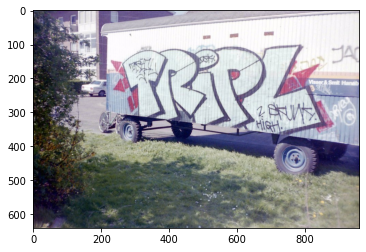

In [12]:
plt.imshow(dataset['data']['image'][8])

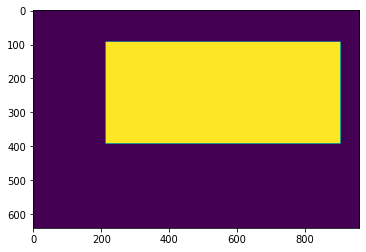

In [11]:
plt.imshow(dataset['data']['label'][8])